<h1>Import Required Libraries</h1>

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

from time import time
import numpy as np

<h1>Data Preprocessing</h1>

In [39]:
my_data_dir = 'D:\\Pycharm\\Anomalous_detection_CNN\\data_four_poses'

In [40]:
os.listdir(my_data_dir) 

['test', 'train']

In [41]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [42]:
os.listdir(test_path)

['climb', 'crawl', 'normal', 'squat']

In [43]:
os.listdir(train_path)

['climb', 'crawl', 'normal', 'squat']

In [44]:
os.listdir(train_path+'\\normal')[0]

'Image0.png'

In [45]:
stick_figure = train_path+'\\normal'+'\\Image0.png'

In [46]:
stick_fig_img = imread(stick_figure)

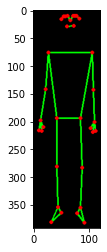

In [47]:
plt.imshow(stick_fig_img)

In [48]:
stick_fig_img.shape

(392, 121, 3)

In [49]:
len(os.listdir(train_path+'\\normal'))

1300

In [50]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\normal'):
    
    img = imread(test_path+'\\normal'+'\\'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

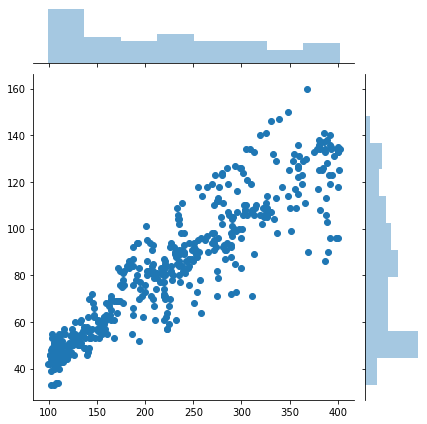

In [51]:
sns.jointplot(dim1,dim2)

In [52]:
np.mean(dim1)

220.694

In [53]:
np.mean(dim2)

81.036

In [54]:
image_shape = (225,85,3)

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
image_gen = ImageDataGenerator(rotation_range=0, # rotate the image 20 degrees
                               width_shift_range=0.0, # Shift the pic width by a max of 5%
                               height_shift_range=0.0, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.0, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.0, # Zoom in by 10% max
                               horizontal_flip=False, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

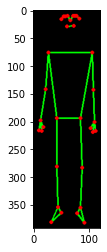

In [57]:
plt.imshow(stick_fig_img)

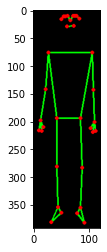

In [58]:
plt.imshow(image_gen.random_transform(stick_fig_img))

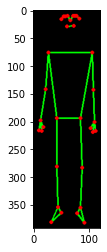

In [59]:
plt.imshow(image_gen.random_transform(stick_fig_img))

In [60]:
image_gen.flow_from_directory(train_path)

Found 5200 images belonging to 4 classes.


In [61]:
image_gen.flow_from_directory(test_path)

Found 2000 images belonging to 4 classes.


In [62]:
batch_size = 16

In [63]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 5200 images belonging to 4 classes.


In [64]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 2000 images belonging to 4 classes.


In [65]:
train_image_gen.class_indices

{'climb': 0, 'crawl': 1, 'normal': 2, 'squat': 3}

<h1>Defining AlexNet architecture</h1>

In [66]:
def alexnet(input_shape, n_classes):
    input = Input(input_shape)

    # actually batch normalization didn't exist back then
    # they used LRN (Local Response Normalization) for regularization
    x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)

    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)

    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)

    x = Conv2D(384, 3, strides=1, padding='same', activation='relu')(x)

    x = Conv2D(256, 3, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(3, strides=2)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

In [67]:
input_shape = 225, 85, 3
n_classes = 4

K.clear_session()
model = alexnet(input_shape, n_classes)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 225, 85, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 22, 96)        34944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 22, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 10, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 10, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 10, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 4, 256)        0   

In [68]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

In [70]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

<h1>Train the model</h1>

In [71]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
325/325 [==============================] - 301s 925ms/step - loss: 0.3154 - accuracy: 0.8873 - val_loss: 5.8367 - val_accuracy: 0.2495
Epoch 2/20
325/325 [==============================] - 325s 999ms/step - loss: 0.0774 - accuracy: 0.9729 - val_loss: 0.0987 - val_accuracy: 0.9440
Epoch 3/20
325/325 [==============================] - 307s 944ms/step - loss: 0.0594 - accuracy: 0.9812 - val_loss: 0.0321 - val_accuracy: 0.9525
Epoch 4/20
325/325 [==============================] - 297s 914ms/step - loss: 0.0271 - accuracy: 0.9921 - val_loss: 0.3252 - val_accuracy: 0.9500
Epoch 5/20
325/325 [==============================] - 385s 1s/step - loss: 0.0467 - accuracy: 0.9867 - val_loss: 0.0803 - val_accuracy: 0.9525


In [72]:
from tensorflow.keras.models import load_model
model.save('AlexNET_four_poses_1.h5')

<h1>Evaluate and Visualize Metrics</h1>

In [73]:
losses = pd.DataFrame(model.history.history)

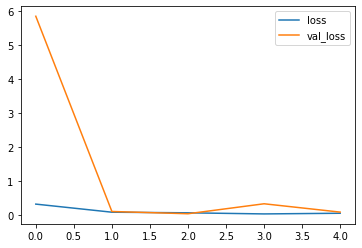

In [74]:
losses[['loss','val_loss']].plot()

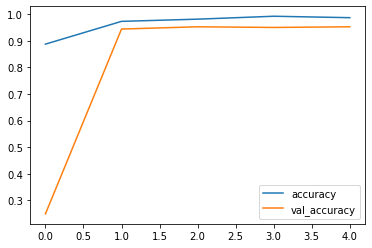

In [75]:
losses[['accuracy','val_accuracy']].plot()

In [76]:
model.metrics_names

['loss', 'accuracy']

In [77]:
model.evaluate_generator(test_image_gen)

[0.08032878488302231, 0.9524999856948853]

In [78]:
from tensorflow.keras.preprocessing import image

<h1>Test the model on Sample Image</h1>

In [79]:
predictions = model.predict(test_image_gen)

In [80]:
predictions

array([[1.0000000e+00, 9.9642037e-09, 1.0054423e-09, 1.5357308e-08],
       [1.0000000e+00, 2.9910336e-08, 5.0210978e-09, 5.3096546e-08],
       [9.9999976e-01, 1.7692095e-07, 8.3758600e-09, 1.1403696e-07],
       ...,
       [1.4207760e-05, 1.5498116e-09, 1.4182026e-03, 9.9856758e-01],
       [4.1315940e-04, 1.3250491e-06, 1.5651865e-02, 9.8393363e-01],
       [1.3292485e-05, 7.9440170e-09, 9.8776654e-04, 9.9899894e-01]],
      dtype=float32)

In [81]:
def prediction_classes(p):
    max_value  = 0
    maxi = 0
    for i in range(4):
        temp = p[i]
        if temp>max_value:
            max_value = temp
            maxi = i
    return maxi

In [82]:
predictions = map(prediction_classes, predictions)

pred = list(predictions)

In [83]:
pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [84]:
pred = np.array(pred)

In [85]:
pred

array([0, 0, 0, ..., 3, 3, 3])

In [86]:
test_image_gen.classes

array([0, 0, 0, ..., 3, 3, 3])

In [87]:
from sklearn.metrics import classification_report,confusion_matrix

In [88]:
print(classification_report(test_image_gen.classes,pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       500
           1       1.00      0.88      0.93       500
           2       0.94      0.96      0.95       500
           3       0.94      0.98      0.96       500

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [89]:
confusion_matrix(test_image_gen.classes,pred)

array([[496,   1,   3,   0],
       [ 28, 439,  16,  17],
       [  4,   0, 481,  15],
       [  1,   1,   9, 489]], dtype=int64)

In [90]:
test_image_gen.class_indices

{'climb': 0, 'crawl': 1, 'normal': 2, 'squat': 3}